In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
from io_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm

sns.set_context("talk")

ibl_data_path = '../data_IBL'
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
colorsStates = ['darkorange','darkblue','forestgreen','purple']
myFeatures = [['bias','contrast left','contrast right', 'previous choice', 'previous reward'],['bias','signed stimulus', 'previous choice', 'previous reward']]
sns.set_context("talk")
colormap = ['rebeccapurple','teal','darkturquoise','springgreen']

In [2]:
# NO LONGER WORKING, FIND NEW WAY TO DONWLAOD DATA


# # Downloading data, then unzipping manually in folder, then preprocessing with below code, adapted from Psytrack notebook (Roy et al., 2021)

# current_cwd = os.getcwd()
# SPATH = current_cwd 
# ibl_data_path = SPATH + '/../data_IBL'
# os.chdir(ibl_data_path)
# print(os.getcwd())

# !pip install ibllib
# # !wget -nc -O "{SPATH}ibl-behavior-data-Dec2019.zip" "https://ndownloader.figshare.com/files/21623715"
# # !unzip -d "{SPATH}" -n "{SPATH}ibl-behavior-data-Dec2019.zip"

# from ibllib import ONE


# import subprocess

# def runcmd(cmd, verbose = False, *args, **kwargs):

#     process = subprocess.Popen(
#         cmd,
#         stdout = subprocess.PIPE,
#         stderr = subprocess.PIPE,
#         text = True,
#         shell = True
#     )
#     std_out, std_err = process.communicate()
#     if verbose:
#         print(std_out.strip(), std_err)
#     pass

# runcmd('echo "Hello, World!"', verbose = True)

# runcmd("wget https://ndownloader.figshare.com/files/21623715", verbose = True)

# # Search all sessions that have these dataset types.
# required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
#                  '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
# one = ONE()
# eids = one.search(required_vars)

# mouseData = pd.DataFrame()
# for eid in eids:
#     lab, _, subject, date, session = eid.split("/")    
#     sess_vars = {
#         "eid": eid,
#         "lab": lab,
#         "subject": subject,
#         "date": date,
#         "session": session,
#     }
#     mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)

# all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
# df = pd.DataFrame()

# all_mice = []
# for j, s in enumerate(mouseData["subject"].unique()):
#     print("\rProcessing " + str(j+1) + " of " + str(len(mouseData["subject"].unique())), end="")
#     mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
#     for i, row in mouse.iterrows():
#         myVars = {}
#         for v in all_vars:
#             filename = "_ibl_trials." + v + ".npy"
#             var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
#             myVars[v] = list(np.load(var_file).flatten())

#         num_trials = len(myVars[v])
#         myVars['lab'] = [row.lab]*num_trials
#         myVars['subject'] = [row.subject]*num_trials
#         myVars['date'] = [row.date]*num_trials
#         myVars['session'] = [row.session]*num_trials

#         all_mice += [pd.DataFrame(myVars, columns=myVars.keys())]
        
# df = pd.concat(all_mice, ignore_index=True)

# df = df[df['choice'] != 0]        # dump mistrials
# df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit
# df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
# df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
# df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
# df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct
# df["correctSide"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
# df.loc[df["correctSide"]==1, "correctSide"] = 0
# df.loc[df["correctSide"]==-1, "correctSide"] = 1
# df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
# df.loc[df["choice"]==1, "choice"] = 0
# df.loc[df["choice"]==-1, "choice"] = 1
# df.to_csv(SPATH+"ibl_processed.csv", index=False)

In [3]:
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
dfAll.head()

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,correctSide
0,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
1,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
2,0.0,1.0,1,1,1.0,angelakilab,IBL-T1,2019-02-09,1,1
3,0.5,0.0,0,1,0.5,angelakilab,IBL-T1,2019-02-09,1,0
4,0.5,0.0,0,1,0.9,angelakilab,IBL-T1,2019-02-09,1,0


In [4]:
# only looking at animals from 3 labs (32 total animals)
labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

# removing missing or incomplete animals
if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')

In [11]:
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject='ibl_witten_15', sessStop=None, signedStimulus=False, pTanh=5)

subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


In [17]:
# concatanating post-training data across half the mice into one global dataset
firstSubject = 'ibl_witten_02'
signedStimulus = True #True
pTanh = None
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject=firstSubject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) 
c = 0
for subject in subjectsWitten: #subjectsAll:
    if (subject != firstSubject):
        xTemp, yTemp, sessIndTemp, correctSideTemp = get_mouse_design(dfAll, subject=subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) 

        # only using post-training data
        _, _, _, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessIndTemp, sessStop=None) # session of first biased block introduced & end of training
        if firstBlockSession is not np.nan:
            firstIndex = sessIndTemp[firstBlockSession]
            xTemp = xTemp[firstIndex:]
            yTemp = yTemp[firstIndex:]
            sessIndTemp = sessIndTemp[firstBlockSession:]
            sessIndTemp = [i - firstIndex for i in sessIndTemp]

            x = np.concatenate((x,xTemp))
            y = np.concatenate((y,yTemp))
            sessInd = sessInd + [i + sessInd[-1] for i in sessIndTemp[1:]]
    
    c += 1
print(x.shape)
print(y.shape)
np.save(f'../data_IBL/X_wittenAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}', x)
np.save(f'../data_IBL/Y_wittenAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}', y)
np.save(f'../data_IBL/sessInd_wittenAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}', sessInd)

x = np.load(f'../data_IBL/X_wittenAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}.npy')
y = np.load(f'../data_IBL/Y_wittenAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}.npy')
sessInd = np.load(f'../data_IBL/sessInd_wittenAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}.npy')

(544037, 4)
(544037,)


In [7]:
print(x.shape)
print(y.shape)
print(sessInd[-1])

(629730, 5)
(629730,)
629730


(1, 5, 2)
(2, 5, 2)
(3, 5, 2)


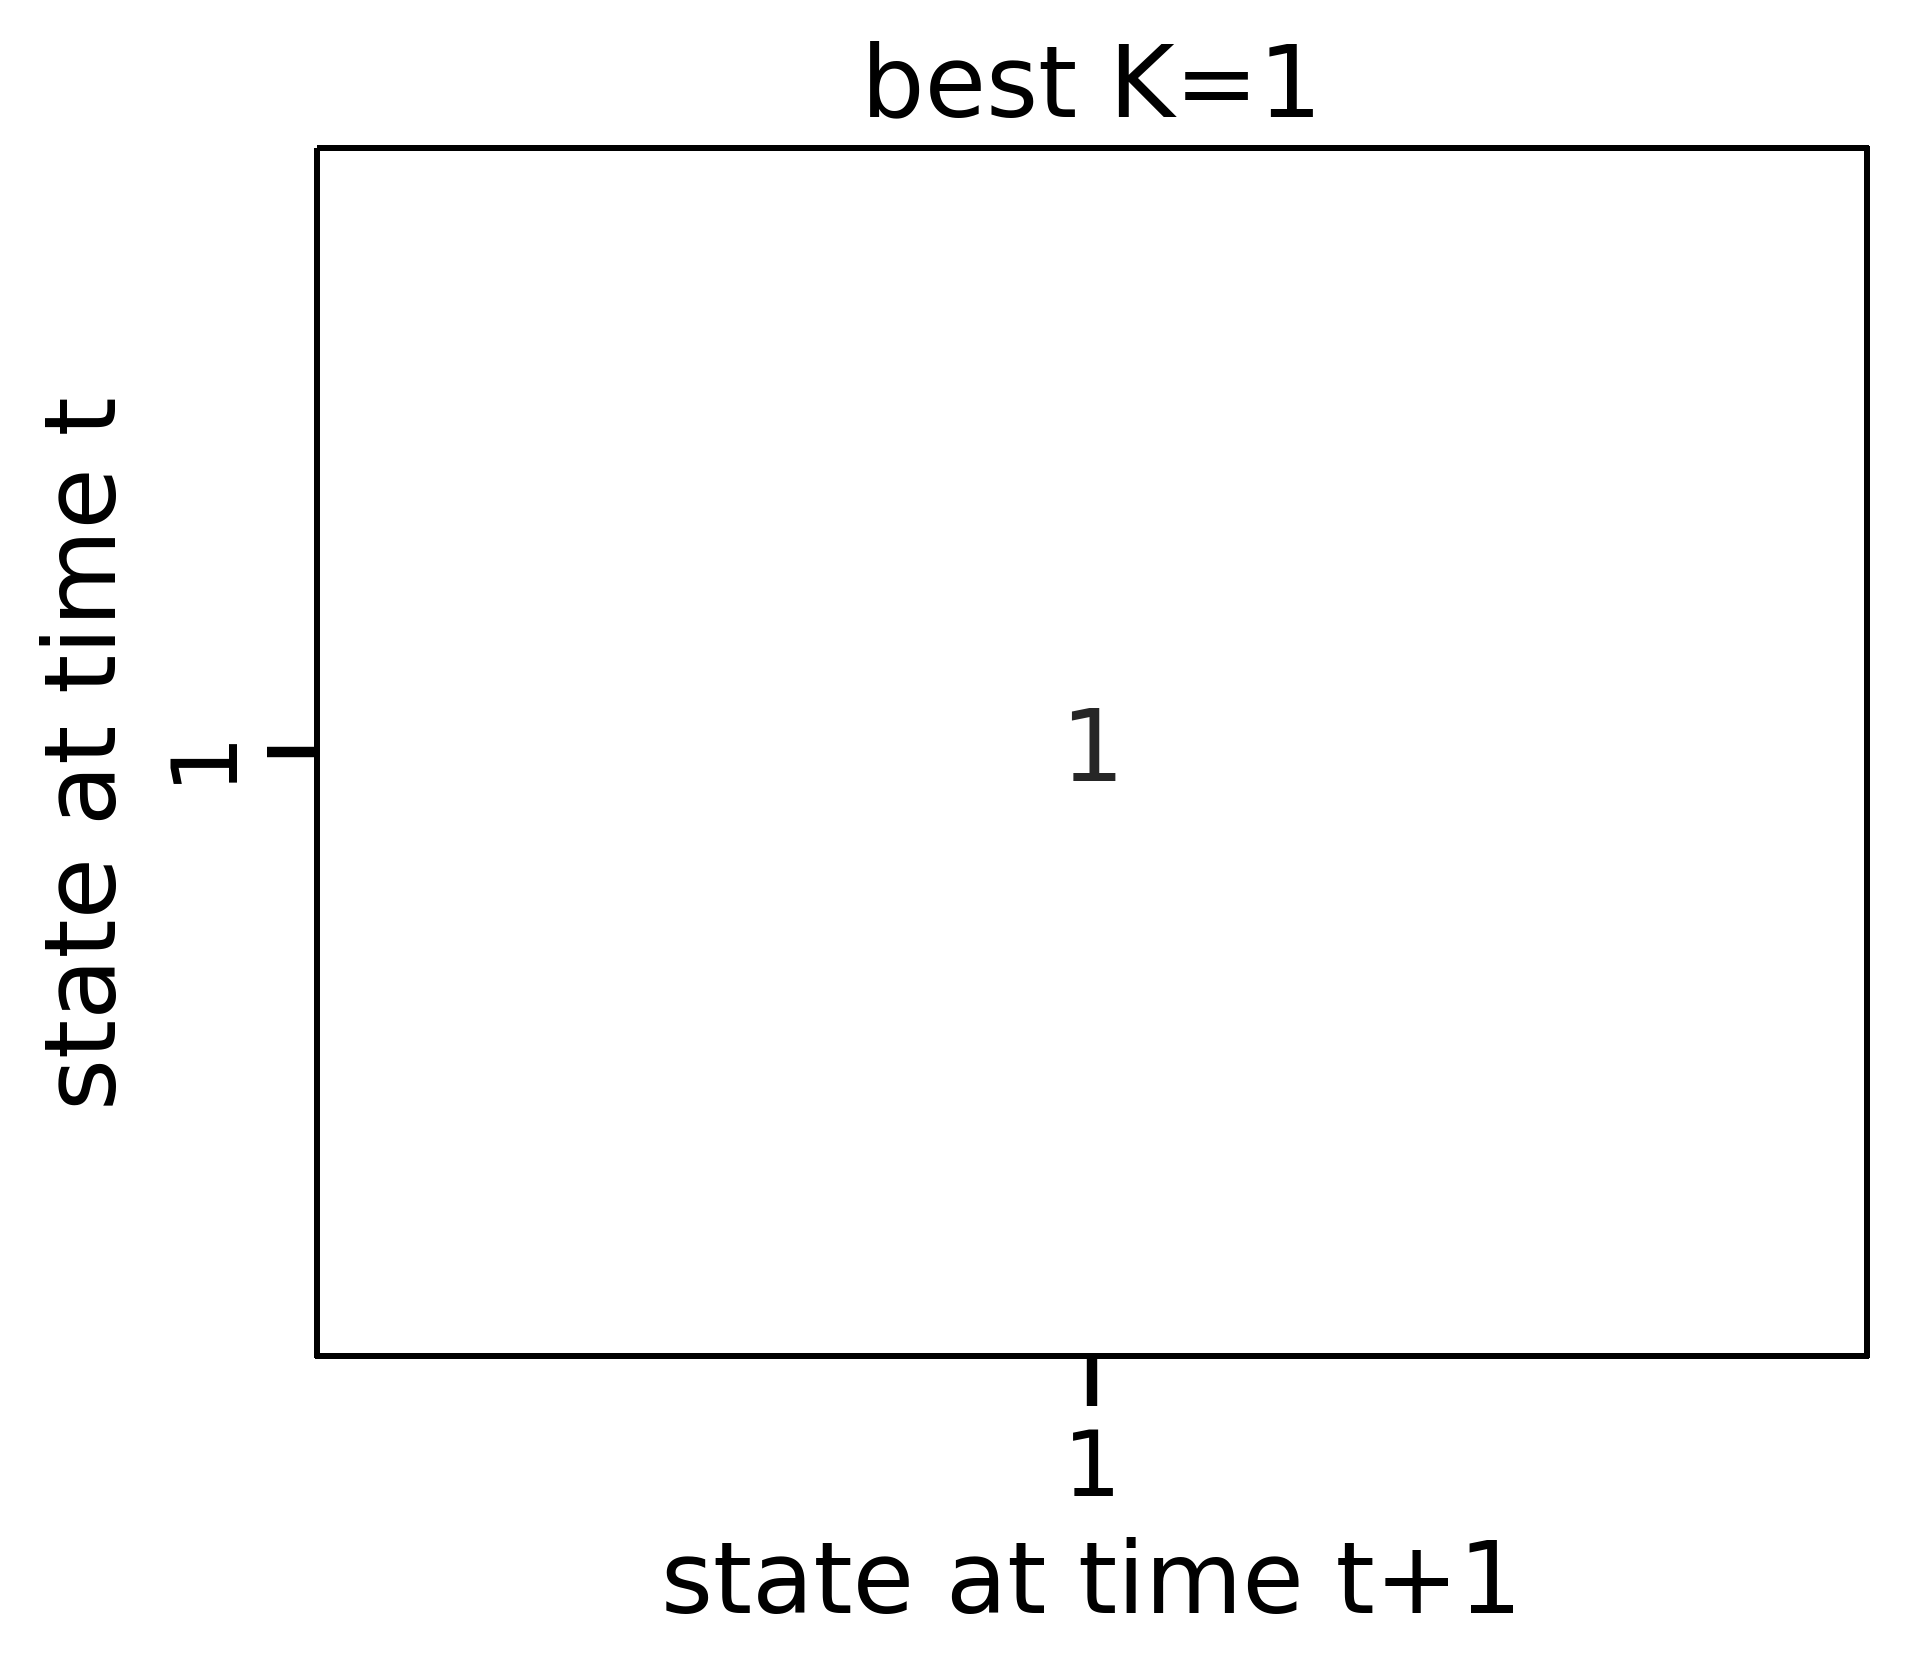

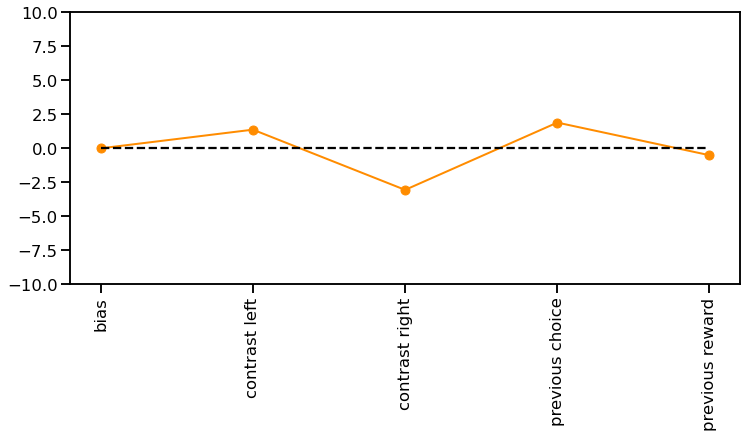

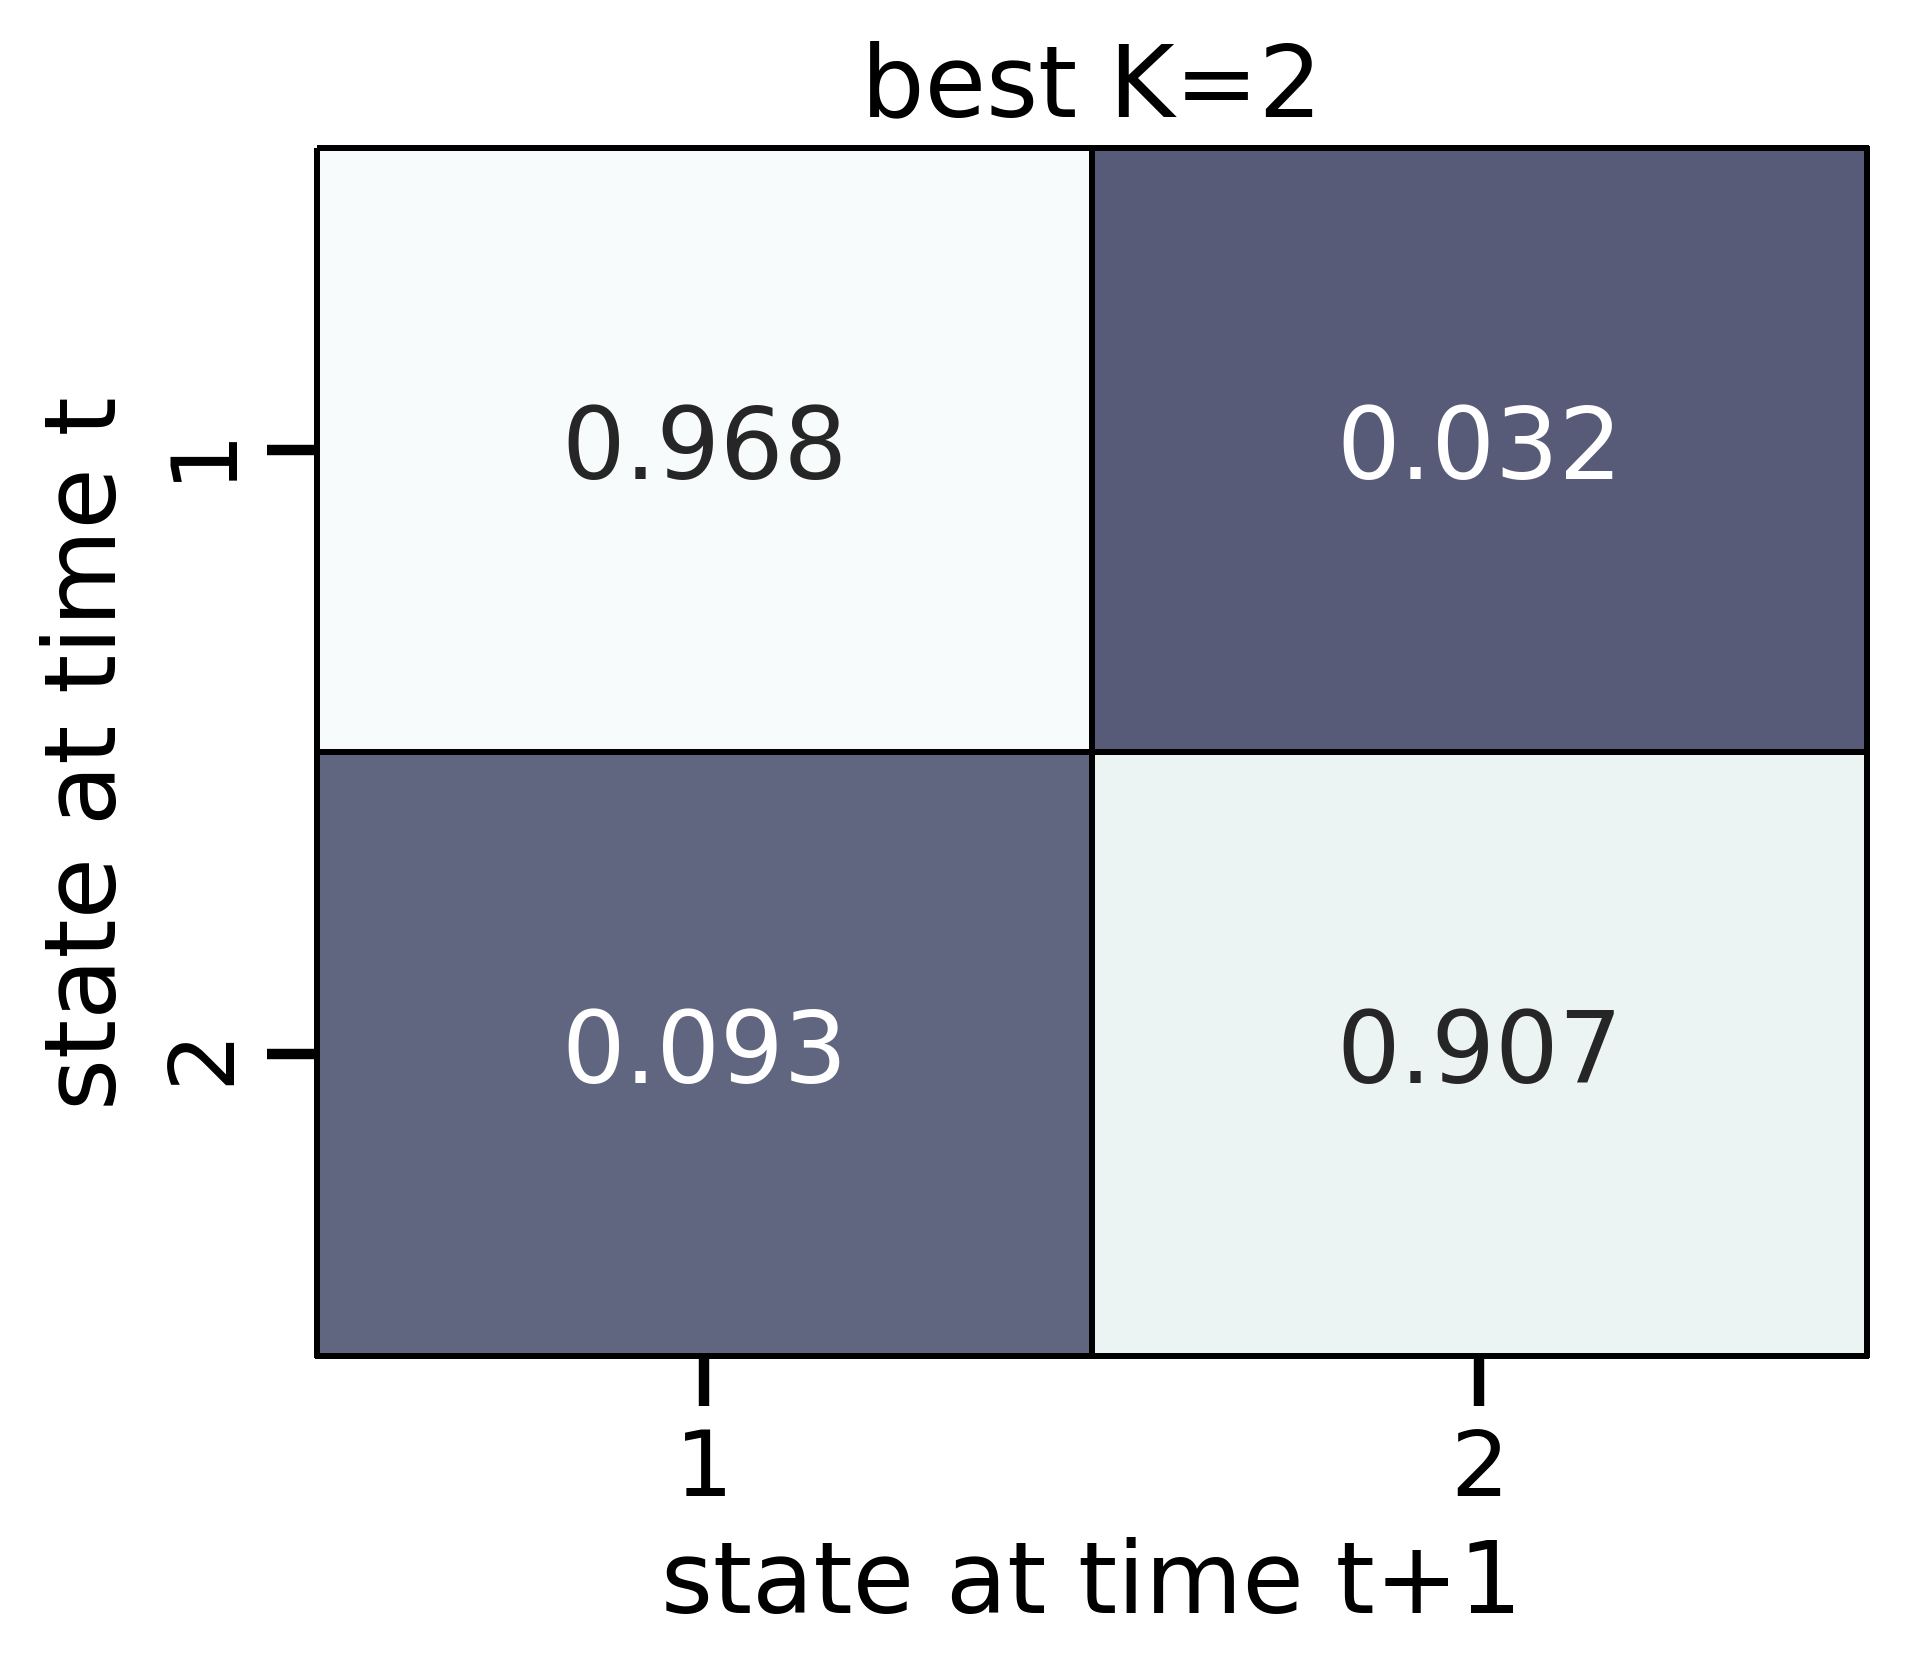

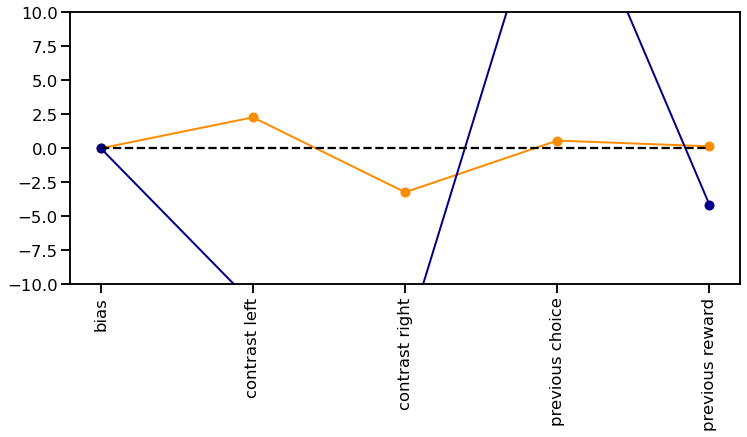

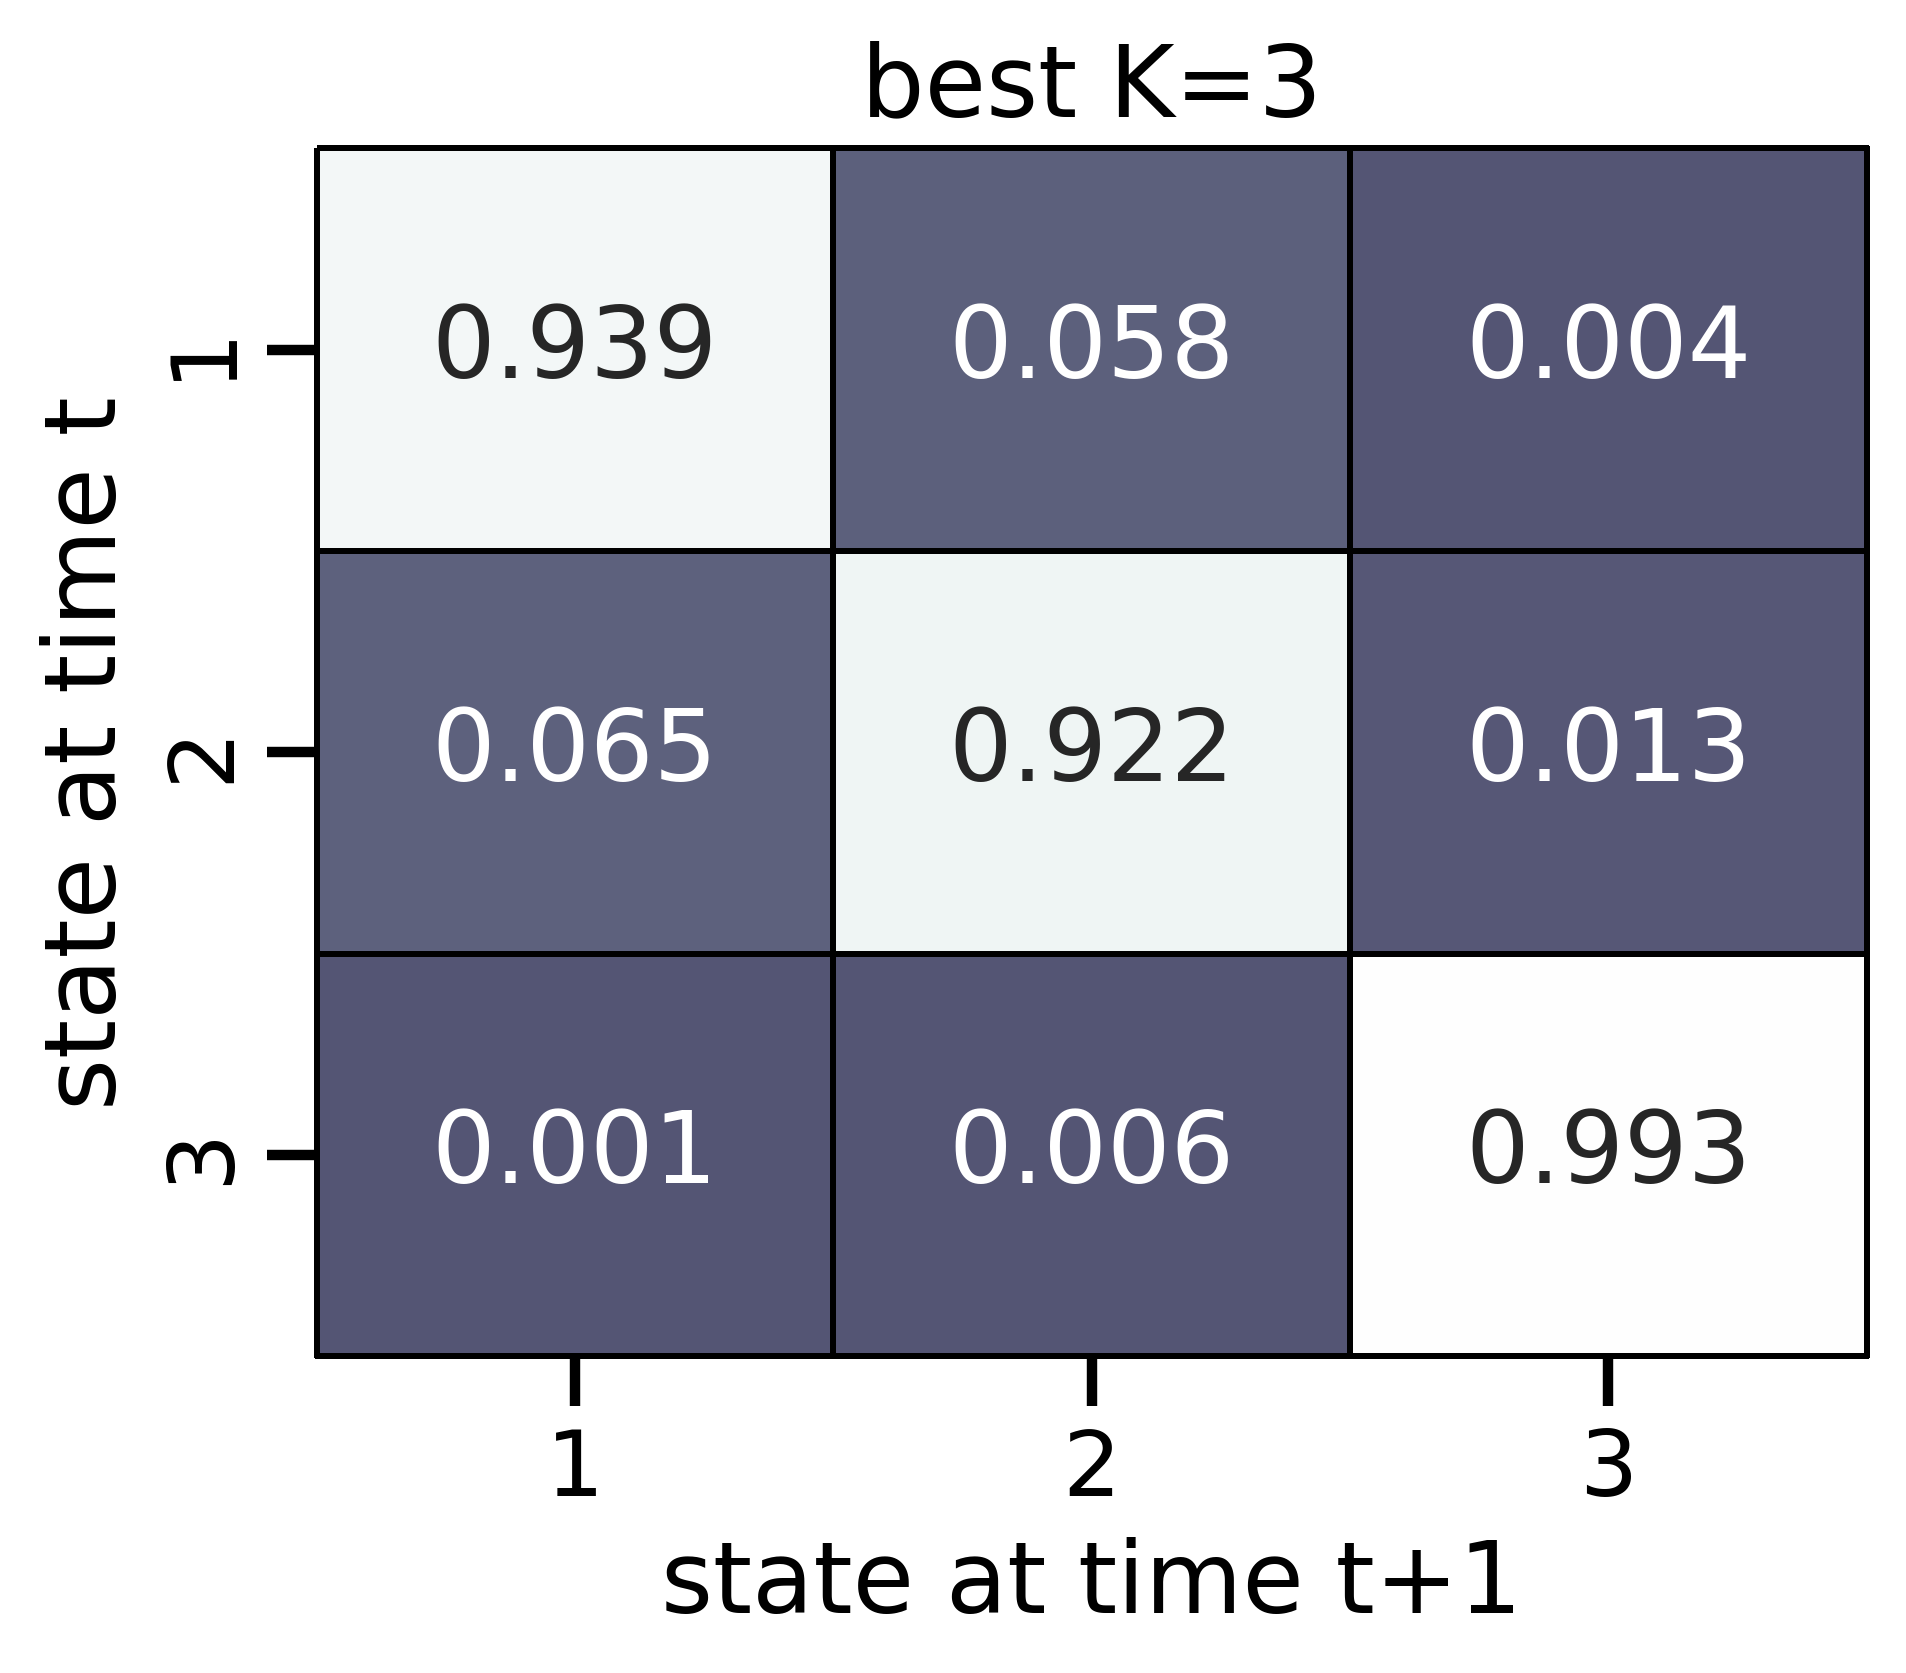

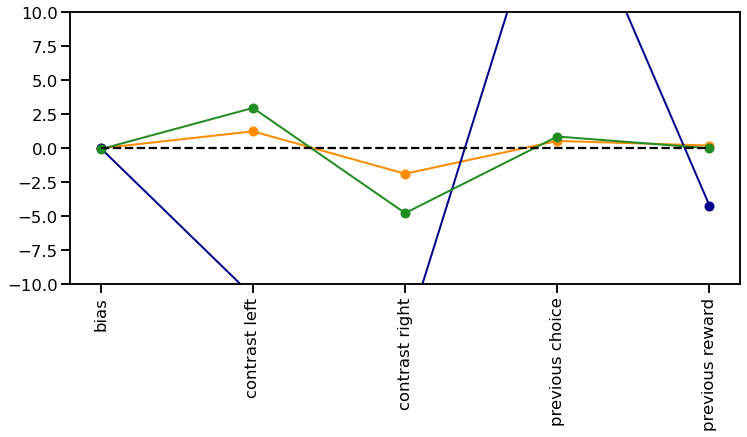

In [9]:
signedStimulus = False
D = 4
C = 2
inits = 20
for K in [1,2,3]:#,4,5]:
    df = pd.DataFrame(columns=['trainLl', 'trainAccuracy' ,'P', 'pi', 'W']) 
    for init in range(0,inits):
        data = np.load(f'../data_IBL/allAnimals_standardGLMHMM_{K}-state_init={init}_signedStimulus={signedStimulus}.npz')
        df.loc[init, 'P'] = data['P']
        df.loc[init, 'pi'] = data['pi']
        df.loc[init, 'W'] = data['W']
        df.loc[init, 'trainLl'] = data['trainLl']

    # print(ll)
    ll = np.array(df['trainLl']).flatten()
    bestInd = np.argmax(ll)

    print(df.loc[bestInd, 'W'][0].shape)
    # reorder parameters if necessary

    # plot parameters
    plot_transition_matrix(df.loc[bestInd, 'P'][0], title=f'best K={K}')
    fig, axes = plt.subplots(1, figsize=(12,5))
    plot_constant_weights(df.loc[bestInd, 'W'][0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
    axes.set_ylim(-10,10)


    # saving best models
    np.savez(f'../data_IBL/Best_standardGLMHMM_halfAnimals_signedStimulus={signedStimulus}_{K}-state', P=df.loc[bestInd, 'P'], pi=df.loc[bestInd, 'pi'], W=df.loc[bestInd, 'W'])
    
